#Problem Definition 
Human errors remain the largest contributing factor to safety and congestion related incidents, approximately 94% of all motor‐vehicle accidents, leading to over 33,000 national annual fatalities, from 2009 through 2014. In addition, congestion related system inefficiencies wastes an annual $160B in time and fuel, and accounts for nearly 24% of the Greenhouse Gas Emissions throughout the US. [1]  
We wish to address these issues by detecting lane-level events through deploying CAV-Enabled Corridors. Such lane-level events include, but are not limited to, peak lane demand/congestion, minimum and maximum velocities of road-users, volume and class of road-users per lane, anomalous lane-to-lane behavior, as well as the identification of hazards such as pedestrians, debris or wrong-way driving vehicle in the roadway/shoulder.

#Approach  
Lane-level event detection supported by a series of computer vision and machine learning based technologies developed by us, including object detection, localization and tracking of objects of interest in video feeds monitoring these corridors. At this stage, we work closely with the customer and the current state of the art to ensure a proper solution is deployed to the customer's satisfaction.  

![Corridor Monitor](https://www.gifntext.com/temp_generations/O3bWHF07.gif "Corridor Monitor")


#Data Gathering    
The power of a machine learning (ML) system comes from the quality of its data. Any customer sponsored data that can be made available could be useful in initial iterations of the ML model. Useful data includes measurements of interest collected, such as through manual labeling, pilot vehicles, etc. secondary measurements, such as meterological data, as well as source data from which those measurements can be reproduced, such as video feeds.  
If customer data is supplied, we must take time to understand what each of the fields represent and what the data types are so that the information can be parsed and used as input to the ML model.  
In the absense of customer data, we can bootstrap ML model training by using publicly available datasets such as the KITTI Benchmark Suite [http://www.cvlibs.net/datasets/kitti/].

In [ ]:
import random
import numpy as np
dataset_name = ['State Route 6','I80']
avg = [int(random.normalvariate(50,6)) for _ in range(8)]
sr6_data = {
    'Start Time': ('22900','23000')+tuple(['230'+a+'0' for a in [str(b) for b in range(1,9)]]), 
    'avg': ('50','50')+tuple(avg), 
    'PC':('46','46')+tuple([round(a,3) for a in np.array(avg)*-0.8 + 65]), 
    'Foo': ('Bar','Bar')*5, 
    'Video Feed': ('corridor.mp4','corridor.mp4')+tuple(['corridor'+a+'.mpg' for a in [str(b) for b in range(2,10)]]),
    'ObjectofInterest': tuple(['No']*5)+tuple(['Yes']*2)+tuple(['No']*3),
    'Anomalous Event': tuple(['Yes']*5)+tuple(['No']*2)+tuple(['No']*3)}
i80_data = {
    'Start Time': ('64000','','64020')+tuple(['640'+a+'0' for a in [str(b) for b in range(3,10)]]), 
    'Average Speed': ('70','999','72')+tuple(np.array(avg[:-1])+22), 
    'Peak Congestion':('34','NaN','32')+tuple([round(a,3) for a in (np.array(avg[:-1])+22)*-0.6 + 76]), 
    'Cam Feed': ('640.mpg','corrupt.zzz','642.mpg')+tuple(['64'+a+'.mpg' for a in [str(b) for b in range(3,10)]]),
    'ObjectofInterest': tuple(['No']*4)+tuple(['Yes']*1)+tuple(['No']*5),
    'Anomalous Event': tuple(['No']*5)+tuple(['No']*2)+tuple(['Yes']*3)}
id2name = {}
print(['6:4'+a for a in [str(b) for b in range(3,10)]])
def show_data(data,column_width=16):
  '''display a dictionary as a table'''
  assert(len(data)>0)
  print(id(data),':')
  print('',end="|")
  for entry in data:
    print(f"{entry:^{column_width}}",end="|")
  print('\n',end="|")
  for _ in data:
    print('-'.join(['']*(column_width+1)),end="|")
  print('\n',end="|")
  row = 0
  while(True):
    for column in data:
      if(row >= len(data[column])): print(f"{(''):^{column_width*len(data)+len(data)-1}}",end='|\n'); return
      print(f"{str(data[column][row]):^{column_width}}",end='|')
    print('\n',end="|")
    row+=1

all_data = [sr6_data,i80_data]
for data in all_data:
  show_data(data)

['6:43', '6:44', '6:45', '6:46', '6:47', '6:48', '6:49']
140407715224064 :
|   Start Time   |      avg       |       PC       |      Foo       |   Video Feed   |ObjectofInterest|Anomalous Event |
|----------------|----------------|----------------|----------------|----------------|----------------|----------------|
|     22900      |       50       |       46       |      Bar       |  corridor.mp4  |       No       |      Yes       |
|     23000      |       50       |       46       |      Bar       |  corridor.mp4  |       No       |      Yes       |
|     23010      |       53       |      22.6      |      Bar       | corridor2.mpg  |       No       |      Yes       |
|     23020      |       61       |      16.2      |      Bar       | corridor3.mpg  |       No       |      Yes       |
|     23030      |       55       |      21.0      |      Bar       | corridor4.mpg  |       No       |      Yes       |
|     23040      |       50       |      25.0      |      Bar       | corridor


#Data Preparation  
At this stage, we take ownership of the data we have received. We combine, format, and make sure we understand what data in each of the columns represent.
If at this stage, we can query the data for specific features and we understand what they are, we are ready to move on the to preparing the data. If there are any columns that we do not understand or are labeled poorly, we need to go back to the data gathering stage and clarify the meaning of any unknown features. In the example, we need to understand the Foo column, as well as clarify the meaning of the PC and avg labels. Learning that these are Peak Congestion and Average Speed, respectively, we can then merge them between the two datasets.

In [ ]:
from datetime import datetime
import numpy as np

# Formatting rules for columns
format_rules = {\
'Average Speed' : (lambda s: float(s)),
'Start Time' : (lambda s: float(s)),
'Peak Congestion' : (lambda s: int(s)),
'subset_id' : lambda s: id2name[s],
'Video Feed': lambda s: s[:s.rfind('.')]+'.mp4' if s[s.rfind('.'):]!='.zzz' else 'INVALID'}
join_rules = {'Foo':['Foo'],'Start Time':['Start Time'],'Average Speed':['Average Speed','avg'],'Video Feed':['Video Feed','Cam Feed'],'Peak Congestion':['PC','Peak Congestion'],'Anomalous Event':['Anomalous Event'],'ObjectofInterest':['ObjectofInterest']}
def parse_entry(entry,column):
  '''parse entries using set of predefined rules based on column type'''
  try: 
    return format_rules[column](entry) if column in format_rules else entry
  except ValueError as ve: 
    return np.nan

def parse_column(data,column):
  '''parse a column of data to a list of valid python datatypes if possible'''
  data[column] = [parse_entry(s,column) for s in data[column]]

def format_data(data):
  '''format each column of a table of data'''
  for column in data: parse_column(data,column)
def prepare_data(all_data, label_map):
  prepared_data = dict()
  column_height = 0
  for idx,data in enumerate(all_data):
    id2name[f'{id(data)}'] = dataset_name[idx]
    for label in label_map:
      for duplicate in label_map[label]:
        if duplicate in data:
          prepared_data[label] = (prepared_data[label] if label in prepared_data else ()) + data[duplicate]
      column_height = max(column_height,len(prepared_data[label]))
    for label in label_map:
      prepared_data[label] += tuple(['']*(column_height-len(prepared_data[label])))
    
    #Add the subset_id entry to the table, a unique identifier for the dataset it came from
    prepared_data['subset_id'] = (prepared_data['subset_id'] if 'subset_id' in prepared_data else ()) + tuple([f'{id(data)}']*(column_height-(len(prepared_data['subset_id']) if 'subset_id' in prepared_data else 0)))

  return prepared_data
prepared_data = prepare_data(all_data,join_rules)
format_data(prepared_data)
show_data(prepared_data)

140407715347984 :
|      Foo       |   Start Time   | Average Speed  |   Video Feed   |Peak Congestion |Anomalous Event |ObjectofInterest|   subset_id    |
|----------------|----------------|----------------|----------------|----------------|----------------|----------------|----------------|
|      Bar       |    22900.0     |      50.0      |  corridor.mp4  |       46       |      Yes       |       No       | State Route 6  |
|      Bar       |    23000.0     |      50.0      |  corridor.mp4  |       46       |      Yes       |       No       | State Route 6  |
|      Bar       |    23010.0     |      53.0      | corridor2.mp4  |       22       |      Yes       |       No       | State Route 6  |
|      Bar       |    23020.0     |      61.0      | corridor3.mp4  |       16       |      Yes       |       No       | State Route 6  |
|      Bar       |    23030.0     |      55.0      | corridor4.mp4  |       21       |      Yes       |       No       | State Route 6  |
|      Bar      

#Data Cleaning  
Once the data has been formatted and merged, the next step is to remove any inconsistencies in the data that might become problematic when it comes time to train a model.  
Actions to take here include removal of any duplicate entries, removal or otherwise correcting any invalid data, interpolating missing values, marking or removing outliers. 
Problems at this stage may signal an error in the preparation stage due to e.g. invalid formatting.  
In this example, the nan values are removed from the Start Time and Peak Congestion columns, and the outlier is removed from the Average Speed Column by way of interpolation. The corrupted video file is identified at this stage as well to prevent the system from trying to interpret it as a valid video file.

In [ ]:

import numpy as np

def is_num(var):
  try:
    int(var)
    return True
  except:
    return False

def clear_outliers(data):
  all_columns = [data[key] for key in data.keys()]
  for column,key in zip(all_columns,data.keys()):
    column=np.array(column)
    if is_num(column[0]):
      z_scores = (np.array(column)-np.mean(column))/np.std(column)
      column[z_scores > 3] = np.median(column) 
    data[key] = column.tolist()

def next_valid_entry(column):
  for entry in column:
    if entry is not np.nan: return entry
  return np.nan

def interpolate_missing(data):
  all_columns = [data[key] for key in data.keys()]
  for column,key in zip(all_columns,data.keys()):
    if is_num(column[0]):
      nanvalues = [np.isnan(entry) for entry in column]
      last_valid_entry = np.nan
      for idx,entry in enumerate(column):
        if np.isnan(entry):
          column[idx] = (next_valid_entry(column[idx:]) + last_valid_entry) / 2
        else: last_valid_entry = entry
    data[key] = column

def clean_data(data):
  #remove_duplicates(data)
  interpolate_missing(data)
  clear_outliers(data)

  return data

clean_data(prepared_data)
show_data(prepared_data)

140407715347984 :
|      Foo       |   Start Time   | Average Speed  |   Video Feed   |Peak Congestion |Anomalous Event |ObjectofInterest|   subset_id    |
|----------------|----------------|----------------|----------------|----------------|----------------|----------------|----------------|
|      Bar       |    22900.0     |      50.0      |  corridor.mp4  |      46.0      |      Yes       |       No       | State Route 6  |
|      Bar       |    23000.0     |      50.0      |  corridor.mp4  |      46.0      |      Yes       |       No       | State Route 6  |
|      Bar       |    23010.0     |      53.0      | corridor2.mp4  |      22.0      |      Yes       |       No       | State Route 6  |
|      Bar       |    23020.0     |      61.0      | corridor3.mp4  |      16.0      |      Yes       |       No       | State Route 6  |
|      Bar       |    23030.0     |      55.0      | corridor4.mp4  |      21.0      |      Yes       |       No       | State Route 6  |
|      Bar      

#Data Analysis  
Frequency distrubution, histogram, bi/multi-feature, insights  
Metrics: can we gather macro statistics, do they make sense  
Now that the data is clean, it's time to run some preliminary analyses to get a macro-view of the data. We do this step to verify at a high level that the data is in a state that can support statistical analyses. If we have any problems at this stage, either with invalid data or nonsensical statistics, the data likely has not been cleaned properly.

   Foo  Start Time  Average Speed  ... Anomalous Event  ObjectofInterest subset_id
10         64000.0           70.0  ...              No                No       I80
11         64010.0           62.0  ...              No                No       I80
12         64020.0           72.0  ...              No                No       I80
13         64030.0           75.0  ...              No                No       I80
14         64040.0           83.0  ...              No               Yes       I80
15         64050.0           77.0  ...              No                No       I80
16         64060.0           72.0  ...              No                No       I80
17         64070.0           63.0  ...             Yes                No       I80
18         64080.0           67.0  ...             Yes                No       I80
19         64090.0           78.0  ...             Yes                No       I80

[10 rows x 8 columns]


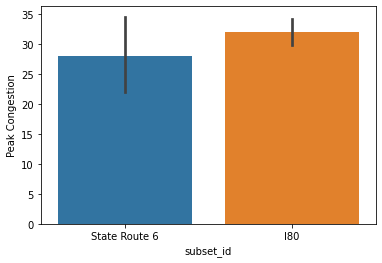

In [ ]:
import seaborn
import pandas
import matplotlib.pyplot as plt
df = pandas.DataFrame(prepared_data)
seaborn.barplot(data=df,x='subset_id',y='Peak Congestion')
print(df[df['subset_id']=='I80'])



#Feature Engineering  
We have viewed the data at the high level, it is time to choose what it is we wish to predict from the data, known as the target variable. If for example we are interesting in forcasting Peak Congestion, we might want to see how it correlates with other features in the data. As can be seen from the simple plots, Average Speed increases as Peak Congestion decreases. Thus we could hypothesize that Average Speed is a good feature for estimating Peak Congestion.  Peak Congestion also seems to correlate with time.  
Other features, such as the Foo are found to not be good indicators for Peak Congestion, at least in their raw form. Processing existing features to obtain new features, known as feature extraction, such as extracting HOG or optical flow features from video feed frames can be useful at this stage to provide a richer input in the model building phase than simply the raw RGB pixel values in the image.  

![HOG Features](https://www.researchgate.net/profile/Joko_Hariyono/publication/263844904/figure/download/fig4/AS:214281711820809@1428100149950/Extraction-process-of-HOG-features-The-HOG-features-are-extracted-from-local-regions.png "HOG Features")  
     HOG Features  

![Optical Flow](https://nanonets.com/blog/content/images/2019/04/of-2.gif "Optical Flow")   

Labeling data can also be performed such that certain portions of for example video feed images are determined to be part of a certain class.

![Data Labeling](https://www.gifntext.com/temp_generations/FZ4uiTua.gif "Data Labeling")  
     Additional Manual Labeling of Video Frames  

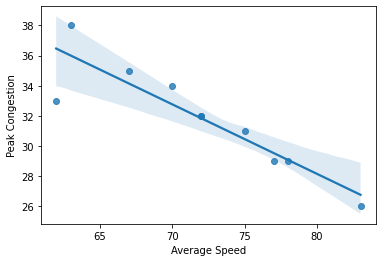

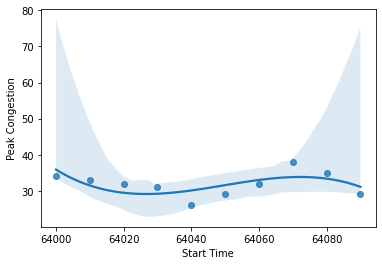

In [ ]:

seaborn.regplot(data=df[df['subset_id']=='I80'],x='Average Speed',y='Peak Congestion')
plt.figure()
seaborn.regplot(data=df[df['subset_id']=='I80'],x='Start Time',y='Peak Congestion',order=3)

#Data Verification  
At this point, we have selected good predictive features from the dataset, it is time to choose candidate models to which to try and fit the data.  Regression techniques such as Linear/Polynomial Regression and Gaussian Process Regression are simple supervised learning techniques to try to predict strictly numerical response variables.  
Classification techniques such as Logistic Regression and Support Vector Machines can be used to predict class labels, such as classifying portions of pre-processed video feed frames as containing objects of interest.  For classifying objects of interest, such as pedestrians, cyclists, motorists, etc. in the video feeds, we could use something like the You Only Look Once (YOLO) deep network model. This is where labeled portions of the video collecting during feature engineering stage become necessary.  
The labeled portions of the images serve as ground truth, or examples chosen by a domain expert, that the network needs to copy by adjusting the parameters or weights in each of its layers. YOLO is an example of a Convolutional Neural Network (CNN), which takes small portions of the input image, slices it up and passes them through a series of layers that continuously shrink the image, which acts as a way to discover objects at different scales in the image, e.g. are there many small examples or few large examples in the image.  
Finally, class labels are predicted in certain regions of the image. We continuously modify the weights at each layer until the ouput begins to match the labeled ground truth classifications.

 
![YOLO Architecture](https://www.researchgate.net/profile/Rui-Jiang-11/publication/312593672/figure/fig1/AS:454309071593483@1485327131630/Convolutional-neural-network-of-the-YOLO-Model.png "YOLO neural network architecture")  
     YOLO Deep Neural Network Architecture 

#Data Sequestering 
At this point, we select a subset of the data on which the train the model, and a different subset of the data to test the performance of the model. It is essential that we test the model on data it did not train on to get a more accurate picture of how well the model generalizes to unseen data. A good split could be 80% training data and the remaining 20% we would use as test data.  
Cross-validation can be performed at this stage as well, meaning the model is trained and tested multiple times, each time with a different 20% chunk as test data, with the remaining used for training.

#Model Building  
Decision trees, random forest, naive bayes, etc.
At this point, we build, or train our candidate models. Here, open-source tools such scikit learn provide a powerful means to building these models. Other tools such as pytorch can be used which allow one to take advantage of any GPUs to speed up training of specifically deep neural networks.  
Complex models, such as deep networks can take hours to several days to train before they start to converge on a model that at least performs well at predicting the training data. The data used as input to the model is carefully selected to speed up time to convergence.  
At each epoch in the training, we evaluate how well it is performing at modeling the training data, using a loss metric such as cross entropy loss, which measures differences between network output and ground truth examples. Once this loss has reached a minimum point, we say that the model has converged and is ready for evaluation.

#Model Evaluation  
Here begins tuning the model. We start by testing how well it performs at predicting the sequestered test data. We can use cross-validation to make the most of the data we have at this stage as well. K-fold cross validation is a technique used to train several models at once using a certain set of hyperparameters on each of K-1 folds of training data. The remaining fold is then used to gather metrics as to the performance of the model on each of the K validation sets.  
Metrics of interest include bias-variance i.e. how well the model generalizes to predicting data not used during training, precision-recall or f1-score an averaging of precision-recall i.e. how strict it is at classifying positive class labels, and accuracy i.e. the percentage of data that was correctly classified. Often times, a confusion matrix visualization of the model classification vs the actual classification is shown to visually inspect its performance, which can help pinpoint any systematic misclassifications, or confusion, between two or more classes.  
In video feeds, a tracking system can be superimposed on the single-frame detection results. This allows for the tracking of individual objects in the scene to obtain features in the time domain such as measurement of movement velocities. Road hazards can be detected by looking for objects with zero movement velocity in the roadway.

#Model Deployment  
Finally the moment we've all been waiting for: deployment!  The model is ready for business consumption. Even at this stage, however, the learning system is has not finished learning. Post-deployment is where we find the richest, nearly limitless source of unseen test data. This is also where we get to scale up the system from a single to multiple learning systems working in parallel in the cloud. Anomalous events captured by one learning system can be made available to all learners simultaneously. We can apply a/b testing at this phase as well such as seeing what happens if we make adjustments to our model or use different sets of data during the training phase. Key Performance Indicators (KPIs) and Measure and Monitor techniques can be leveraged to accurately measure the progress of the learning systems over time. Finally, closing the loop, wherein the learning system continously learns and adjusts based on the data it acquires during deployment, can be performed at this stage as well, which uses a set of trained models and rather than training them from scratch we encorporate new knowledge to try to improve their overall performance. This step remains an active research area.

# Conclusion  
In this article, we have followed a toy dataset through the machine learning life cycle, from acquisition to model building and deployment. The models chosen such as You Only Look Once deep neural network, can detect objects of interest such as pedestrians, in video feeds. Layering a tracking system can increase the performance of single-frame algorithms by incorporating information from the time domain, such as optical flow features. Post-deployment, data can be acquired from the field to continuously improve the quality of the performance of the learning system. Finally, closing is the final step where previously trained models are continuously improved through incorporating new knowledge as it is acquired in the field.

In [ ]:
!apt update
!apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended

import re, pathlib, shutil

# Get a list of all your Notebooks
notebooks = [x for x in pathlib.Path("https://drive.google.com/drive/folders/1V-MbGQ2ZEr-S00cyvIcPfs_W7siaUiHR?usp=sharing").iterdir() if 
             re.search(r"\.ipynb", x.name, flags = re.I)]

for i, n in enumerate(notebooks):
    print(f"\nProcessing  [{i+1:{len(str(len(notebooks)))}d}/{len(notebooks)}]  {n.name}\n")

    # Optionally copy your notebooks from gdrive to your vm
    shutil.copy(n, n.name)
    n = pathlib.Path(n.name)

    !jupyter nbconvert "{n.as_posix()}" --to pdf --output "{n.stem.replace(" ", "_")}"

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [67.9 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:13 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [594 kB]
Get:14 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic